In [52]:
import torch  
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader  
from torchvision.datasets import ImageFolder  

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  

from PIL import Image

# импорт метрик оценки из sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

In [34]:
dataset_path = 'data/'

In [35]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [36]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [37]:
image_datasets = {
    'train': 
    datasets.ImageFolder(dataset_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(dataset_path + 'validation', data_transforms['validation'])
}

In [38]:
image_datasets['train'].classes

['alien', 'predator']

In [39]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=0), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=0)  
}

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [41]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [46]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [47]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.2596, acc: 0.8948
validation loss: 0.4339, acc: 0.7900
Epoch 2/3
----------
train loss: 0.2834, acc: 0.8732
validation loss: 0.2287, acc: 0.9000
Epoch 3/3
----------
train loss: 0.2462, acc: 0.8963
validation loss: 0.3334, acc: 0.8550


In [48]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [49]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

/home/vad/PycharmProjects/jupyter_notebook/class/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_6376/653606346.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.

<All keys matched successfully>

In [53]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(dataset_path + img_path) for img_path in validation_img_paths]

In [54]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [55]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 2.1329, -2.5868],
        [ 0.7293, -1.1770],
        [-1.4055,  1.4789]], grad_fn=<AddmmBackward0>)

In [56]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.9911607 , 0.00883938],
       [0.8706019 , 0.12939815],
       [0.05293178, 0.9470683 ]], dtype=float32)

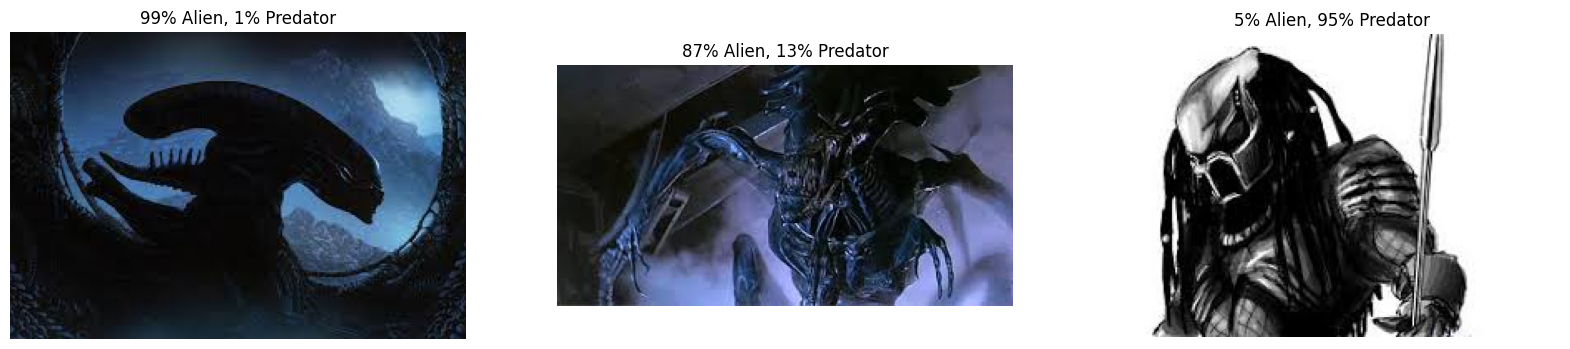

In [57]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)